In [2]:
import os
import requests
from zipfile import ZipFile

In [3]:
def baixar_arquivo(url, endereco):
    #requisição ao servidor
    req = requests.get(url)
    if req.status_code == requests.codes.OK:
        with open(endereco, 'wb') as novo_arquivo:
            novo_arquivo.write(req.content)
        print("Download finalizado. Salvo em: {}".format(endereco))
    else:
        req.raise_for_status()

In [6]:
if __name__ == "__main__":
    #criando pasta para download
    pasta_download = "output"
    if(not os.path.exists(pasta_download)):
        os.mkdir(pasta_download)

    BASE_URL = 'https://portal.inmet.gov.br/uploads/dadoshistoricos/{}.zip'
    OUTPUT_DIR = 'output'
    #armazenando arquivos
    for i in range (2020, 2024):
        nome_arquivo = os.path.join(OUTPUT_DIR, '{}.zip'.format(i))
        baixar_arquivo(BASE_URL.format(i), nome_arquivo)

Download finalizado. Salvo em: output\2020.zip
Download finalizado. Salvo em: output\2021.zip
Download finalizado. Salvo em: output\2022.zip
Download finalizado. Salvo em: output\2023.zip


In [7]:
   #extraindo arquivos
for i in range (2020, 2024):
         with ZipFile('output/{}.zip'.format(i), 'r') as zip:
                zip.extractall(OUTPUT_DIR)
                print("Arquivo {} extraido com sucesso.".format(i))

Arquivo 2020 extraido com sucesso.
Arquivo 2021 extraido com sucesso.
Arquivo 2022 extraido com sucesso.
Arquivo 2023 extraido com sucesso.


In [4]:
import pandas as pd
import datetime
from pathlib import Path
from pandas.api.types import is_numeric_dtype

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
class CONFIG():
    path_csv = Path('output/')
    random_state=42
cfg = CONFIG()

In [6]:
def read_df_info(path_csv):

    head_info = {}
    count = 0
    with open(path_csv, 'r',  encoding = 'unicode_escape') as f:
        for line in f.readlines():
            if count == 8:
                break

            k, v = line.split(';')
            head_info[k] = v[:-1]
            count += 1

    df_info = pd.DataFrame([head_info])
    return df_info

def read_df_data(path_csv):
    df = pd.read_csv(path_csv, sep=';', encoding = 'unicode_escape', engine ='python', skiprows=8)
    return df

In [7]:
def load_df(cfg, samples=1):
    paths = []
    if os.path.isfile(cfg.path_csv):
        paths = [str(cfg.path)]
    else:
        paths = [str(f) for f in cfg.path_csv.glob('**/*.CSV') ]

    paths = pd.DataFrame(paths).sample(samples, random_state=42)
    dfs = []


# Concatenate all data into one DataFrame

    for path in paths.loc[:,0]:
        df_info = read_df_info(path)
        df_data = read_df_data(path)
        for column in df_info.columns:
            df_data.loc[:,column] = pd.Series([df_info[column].loc[0] for _ in range(len(df_data))])
        dfs.append(df_data)

    df_data = pd.concat(dfs, ignore_index=True)
    df_data = df_data.drop('Unnamed: 19', axis = 1)

    # Correção de tipos numericos
    for c_str in  df_data.columns[2:19].tolist() + df_data.columns[23:26].tolist():
        c = df_data[c_str]
        if is_numeric_dtype(c):# c.dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']  :
            df_data.loc[:, [c_str]] = df_data[c_str].apply(np.float32)
        else:
            df_data.loc[:, [c_str]] = df_data[c_str].str.replace(',', '.')
            df_data.loc[:, [c_str]] = df_data[c_str].apply(lambda a: np.float32(pd.to_numeric(a)))

    # Correção de datas
    df_data.loc[:,'Data Hora'] = pd.to_datetime(df_data.Data.astype(str)+' '+ df_data['Hora UTC'].astype(str))
    df_data.loc[:,'DATA DE FUNDACAO:'] = pd.to_datetime(df_data['DATA DE FUNDACAO:'])
    df_data.loc[:,'Data'] = pd.to_datetime(df_data['Data'])
    df_data['timestamp'] = pd.to_datetime(df_data.Data.astype(str)+' '+ df_data['Hora UTC'].astype(str)).apply(lambda d: int(d.timestamp()))
    df_data.set_index('Data Hora',inplace=True)

    return df_data

In [8]:
df = load_df(cfg, samples=35)
df.info()

C:\Users\Winicius\AppData\Local\Temp\ipykernel_1676\4232971632.py:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_data.loc[:, [c_str]] = df_data[c_str].apply(lambda a: np.float32(pd.to_numeric(a)))
C:\Users\Winicius\AppData\Local\Temp\ipykernel_1676\4232971632.py:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_data.loc[:, [c_str]] = df_data[c_str].apply(lambda a: np.float32(pd.to_numeric(a)))
C:\Users\Winicius\AppData\Local\Temp\ipykernel_1676\4232971632.py:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wil

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267000 entries, 2023-01-01 00:00:00+00:00 to 2021-12-31 23:00:00+00:00
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   Data                                                   267000 non-null  datetime64[ns]
 1   Hora UTC                                               267000 non-null  object        
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       160956 non-null  float32       
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  175097 non-null  float32       
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        174967 non-null  float32       
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       174967 non-null  float32       
 6   RADIACAO GLOBAL (Kj/m²)                                107942 non-null  float32       
 7   TEMPERATUR

In [9]:
df.head()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,"VENTO, VELOCIDADE HORARIA (m/s)",REGIAO:,UF:,ESTACAO:,CODIGO (WMO):,LATITUDE:,LONGITUDE:,ALTITUDE:,DATA DE FUNDACAO:,timestamp
Data Hora,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,2023-01-01,0000 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,SE,MG,ARACUAI,A566,-16.848888,-42.035278,308.0,2017-05-19,1672531200
2023-01-01 01:00:00+00:00,2023-01-01,0100 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,SE,MG,ARACUAI,A566,-16.848888,-42.035278,308.0,2017-05-19,1672534800
2023-01-01 02:00:00+00:00,2023-01-01,0200 UTC,0.0,980.200012,980.299988,979.799988,NaN,24.000000,18.100000,24.500000,...,0.5,SE,MG,ARACUAI,A566,-16.848888,-42.035278,308.0,2017-05-19,1672538400
2023-01-01 03:00:00+00:00,2023-01-01,0300 UTC,0.0,980.000000,980.299988,980.000000,NaN,24.700001,18.299999,24.799999,...,3.0,SE,MG,ARACUAI,A566,-16.848888,-42.035278,308.0,2017-05-19,1672542000
2023-01-01 04:00:00+00:00,2023-01-01,0400 UTC,0.0,979.799988,980.000000,979.700012,NaN,23.900000,18.500000,24.700001,...,0.0,SE,MG,ARACUAI,A566,-16.848888,-42.035278,308.0,2017-05-19,1672545600


Text(0, 0.5, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')

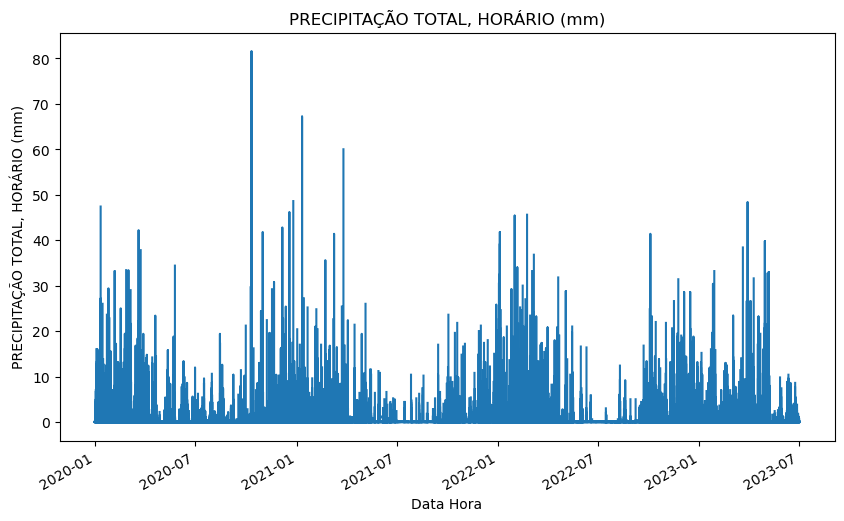

In [10]:
df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot(figsize=(10,6),title='PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')
plt.ylabel('PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')

In [11]:
df.columns

Index(['Data', 'Hora UTC', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'REGIAO:', 'UF:', 'ESTACAO:',
       'CODIGO (WMO):', 'LATITUDE:', 'LONGITUDE:', 'ALTITUDE:',
       'DATA DE FUNDACAO:', 'timest

In [12]:
# Remove and add columns
def preprocessing_begin(df):
    df_data = df.copy()

    df_data['hora']= df_data['Hora UTC'].apply(lambda s: np.float32(s.split(' ')[0])/100)
    df_data['mes']= df_data.Data.apply(lambda d: d.month)
    df_data['ano']= df_data.Data.apply(lambda d: d.year)
    df_data['dia']= df_data.Data.apply(lambda d: d.day)
    df_data['semana']= df_data.Data.apply(lambda d: d.week)
    df_data['choveu']= df_data['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].apply(lambda p: 1 if p > 0 else 0)

    df_data.drop(['Data', 'Hora UTC', 'REGIAO:', 'UF:', 'ESTACAO:',
       'CODIGO (WMO):', 'LATITUDE:', 'LONGITUDE:', 'ALTITUDE:',
       'DATA DE FUNDACAO:'], axis=1, inplace=True)

    return df_data

df_learn = preprocessing_begin(df)
df_learn.isnull().sum()

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         106044
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)     91903
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)           92033
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)          92033
RADIACAO GLOBAL (Kj/m²)                                  159058
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)              92840
TEMPERATURA DO PONTO DE ORVALHO (°C)                     107793
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                92973
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                92973
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         107182
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         108470
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 106112
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 108143
UMIDADE RELATIVA DO AR, HORARIA (%)                      107172
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                      98923
VENTO, RAJADA MAXIMA (m/s)              

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

df_learn_c = df_learn.fillna(-99999) # clean_dataset(df_learn)
X = df_learn_c.loc[:, 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)':'semana']
y = df_learn_c.loc[:, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
y_class = df_learn.loc[:, 'choveu']

X_oversampled, y_oversampled = resample(X[y_class == 1],
                                        y[y_class == 1],
                                        replace=True,
                                        n_samples=X[y_class == 0].shape[0],
                                        random_state=cfg.random_state)

_, y_oversampled_class = resample(X[y_class == 1],
                                        y_class[y_class == 1],
                                        replace=True,
                                        n_samples=X[y_class == 0].shape[0],
                                        random_state=cfg.random_state)


X_balanced = np.vstack((X[y == 0], X_oversampled))
y_balanced = np.hstack((y[y == 0], y_oversampled))
y_balanced_class = np.hstack((y_class[y == 0], y_oversampled_class))

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, stratify=y_balanced_class, test_size=0.25,  random_state=cfg.random_state)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_balanced, y_balanced_class, stratify=y_balanced_class, test_size=0.25,  random_state=cfg.random_state)

In [18]:
#REGRESSÃO - svm.SVR

In [14]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn import svm

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    # ('select', SelectKBest(chi2, k=3)),

    # ('regression', LinearRegression())
    ('regression', svm.SVR())
])

In [32]:
import time

# parte do código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train, y_train)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")


O código demorou 11360 segundos


In [33]:
from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.1432594048720788

In [34]:
mean_squared_error(y_test, y_pred)

11.242685800271493

In [ ]:
#REGRESSÃO - KNeighborsRegressor

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', StandardScaler()),

    # ('select', SelectKBest(chi2, k=3)),

    # ('regression', KNeighborsRegressor())
    ('regression', KNeighborsRegressor(n_neighbors=2))
])

In [36]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train, y_train)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 3154 segundos


In [37]:
from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.021751683

In [38]:
mean_squared_error(y_test, y_pred)

0.14484319

In [ ]:
#REGRESSÃO - MLPRegressor

In [26]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    # ('select', SelectKBest(chi2, k=3)),

    # ('regression', MLPRegressor())
    ('regression', MLPRegressor())
])

In [27]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train, y_train)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 3426 segundos


C:\Users\Winicius\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.6572169056899246

In [30]:
mean_squared_error(y_test, y_pred)

7.856628051540924

In [ ]:
#REGRESSÃO - linear_model.LinearRegression

In [39]:
from sklearn import linear_model

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    # ('select', SelectKBest(chi2, k=3)),

    # ('regression', linear_model.LinearRegression)
    ('regression', linear_model.LinearRegression())
])

In [40]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train, y_train)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 3170 segundos


In [41]:
from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.6368840327958483

In [42]:
mean_squared_error(y_test, y_pred)

10.725229617126367

In [ ]:
#REGRESSÃO - tree.DecisionTreeRegressor()

In [43]:
from sklearn import tree

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    # ('select', SelectKBest(chi2, k=3)),

    # ('regression', linear_model.LinearRegression)
    ('regression', tree.DecisionTreeRegressor())
])

In [44]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train, y_train)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 3174 segundos


In [45]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.03484841024024305

In [46]:
mean_squared_error(y_test, y_pred)

0.30694031666003163

In [ ]:
#CLASSIFICAÇÃO - svm()

In [15]:
from sklearn import svm

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    ('select', SelectKBest(chi2, k=5)),

    # ('regression', Sipporte vector machine())
    ('classification', svm.SVC())
])

In [16]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train_class, y_train_class)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 8198 segundos


In [17]:
y_pred_class = pipe.predict(X_test_class)

Accuracy 0.7896365194943394
[[22074 15416]
 [ 5934 58067]]


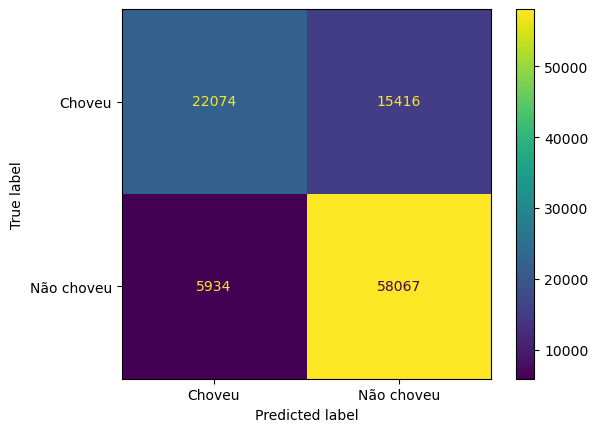

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print ("Accuracy", accuracy_score(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)

print (cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Choveu', 'Não choveu'])
cm_disp.plot()
# confusion_matrix(y_test, y_pred)

In [19]:
from sklearn.metrics import precision_score

print ("Precision", precision_score(y_test_class, y_pred_class))

Precision 0.7902099805397167


In [20]:
#CLASSIFICAÇÃO - Tree

In [21]:
from sklearn import tree

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    ('select', SelectKBest(chi2, k=5)),

    # ('classificação', tree.DecisionTreeClassifier())
    ('classification', tree.DecisionTreeClassifier())
])

In [22]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train_class, y_train_class)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 4374 segundos


In [23]:
y_pred_class = pipe.predict(X_test_class)

Accuracy 0.9778009872796602
[[35240  2250]
 [    3 63998]]


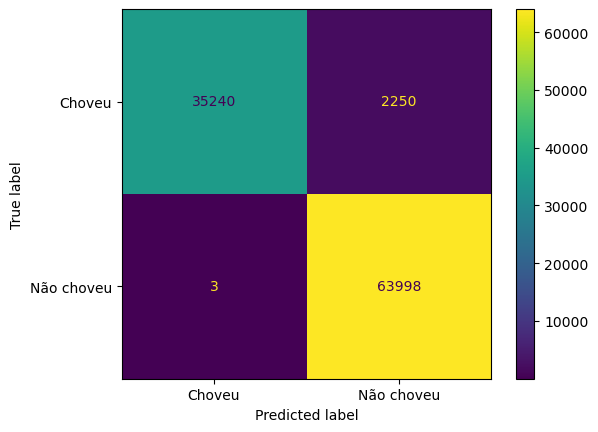

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print ("Accuracy", accuracy_score(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)

print (cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Choveu', 'Não choveu'])
cm_disp.plot()
# confusion_matrix(y_test, y_pred)

In [25]:
from sklearn.metrics import precision_score

print ("Precision", precision_score(y_test_class, y_pred_class))

Precision 0.9660367105422051


In [26]:
#CLASSIFICAÇÃO - SGDClassifier

In [27]:
from sklearn import tree
from sklearn.linear_model import SGDClassifier

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    ('select', SelectKBest(chi2, k=5)),

    # ('classificação', SGDClassifier())
    ('classification', SGDClassifier(loss="hinge", penalty="l2", max_iter=26))
])

In [28]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train_class, y_train_class)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 4376 segundos


In [29]:
y_pred_class = pipe.predict(X_test_class)

Accuracy 0.7483816298982175
[[18900 18590]
 [ 6947 57054]]


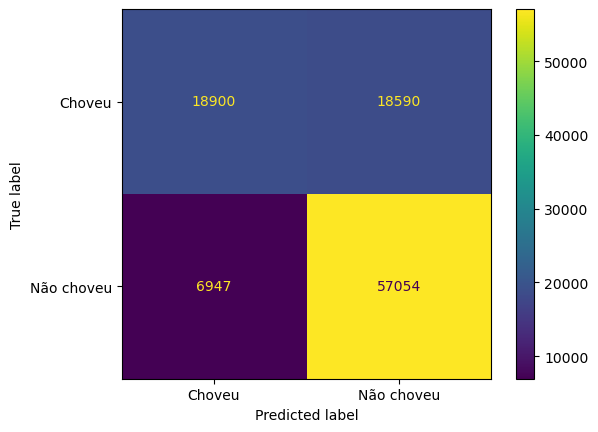

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print ("Accuracy", accuracy_score(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)

print (cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Choveu', 'Não choveu'])
cm_disp.plot()
# confusion_matrix(y_test, y_pred)

In [31]:
from sklearn.metrics import precision_score

print ("Precision", precision_score(y_test_class, y_pred_class))

Precision 0.7542435619480725


In [32]:
#CLASSIFICAÇÃO - NearestCentroid

In [33]:
from sklearn.neighbors import NearestCentroid

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    ('select', SelectKBest(chi2, k=5)),

    # ('classificação', NearestCentroid())
    ('classification', NearestCentroid())
])

In [34]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train_class, y_train_class)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 4378 segundos


In [35]:
y_pred_class = pipe.predict(X_test_class)

Accuracy 0.7350208392862422
[[22777 14713]
 [12180 51821]]


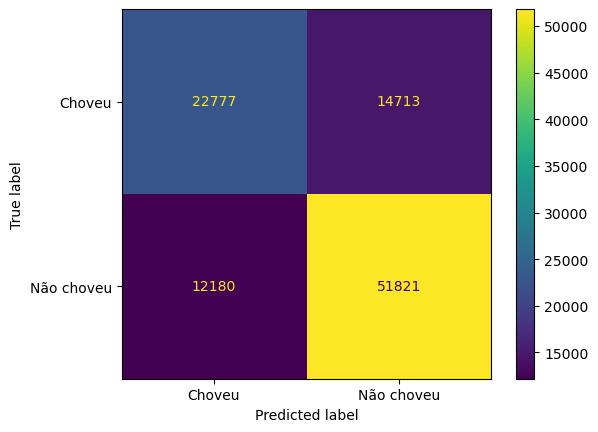

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print ("Accuracy", accuracy_score(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)

print (cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Choveu', 'Não choveu'])
cm_disp.plot()
# confusion_matrix(y_test, y_pred)

In [37]:
from sklearn.metrics import precision_score

print ("Precision", precision_score(y_test_class, y_pred_class))

Precision 0.7788649412330538


In [38]:
#CLASSIFICAÇÃO - GaussianNB

In [39]:
from sklearn.naive_bayes import GaussianNB

pipe = Pipeline([

    # ('imputer', SimpleImputer(missing_values=-10000, strategy='mean')),
    ('imputer', KNNImputer(missing_values=-99999, n_neighbors=10, weights="uniform")),

    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),

    ('select', SelectKBest(chi2, k=5)),

    # ('classificação', GaussianNB())
    ('classification', GaussianNB())     
     ])

In [40]:
# parte código

tempo_inicial = (time.time()) # em segundos

#parte do código que vamos verificar o tempo de execução
pipe.fit(X_train_class, y_train_class)

tempo_final = (time.time()) # em segundos

#Restante do código

#Print do tempo que demorou para rodar a parte específica do código
print(f"O código demorou {int(tempo_final - tempo_inicial)} segundos")

O código demorou 4393 segundos


In [41]:
y_pred_class = pipe.predict(X_test_class)

Accuracy 0.7254337823058202
[[19243 18247]
 [ 9619 54382]]


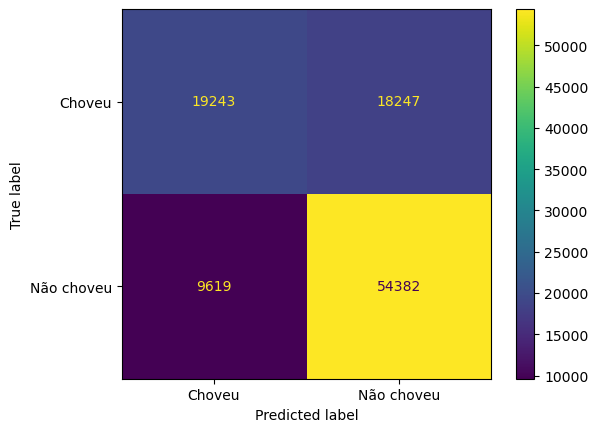

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print ("Accuracy", accuracy_score(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)

print (cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Choveu', 'Não choveu'])
cm_disp.plot()
# confusion_matrix(y_test, y_pred)

In [43]:
from sklearn.metrics import precision_score

print ("Precision", precision_score(y_test_class, y_pred_class))

Precision 0.7487642677167523
